In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


In [31]:
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [32]:
# Downloading stock data for Apple (AAPL) from Yahoo Finance
stock_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
specific_df = pd.DataFrame(stock_data).reset_index()
specific_df['Name'] = 'AAPL'
print(specific_df.head())

[*********************100%%**********************]  1 of 1 completed

        Date       Open       High        Low      Close  Adj Close  \
0 2020-01-02  74.059998  75.150002  73.797501  75.087502  73.152649   
1 2020-01-03  74.287498  75.144997  74.125000  74.357498  72.441460   
2 2020-01-06  73.447502  74.989998  73.187500  74.949997  73.018684   
3 2020-01-07  74.959999  75.224998  74.370003  74.597504  72.675285   
4 2020-01-08  74.290001  76.110001  74.290001  75.797501  73.844360   

      Volume  Name  
0  135480400  AAPL  
1  146322800  AAPL  
2  118387200  AAPL  
3  108872000  AAPL  
4  132079200  AAPL  


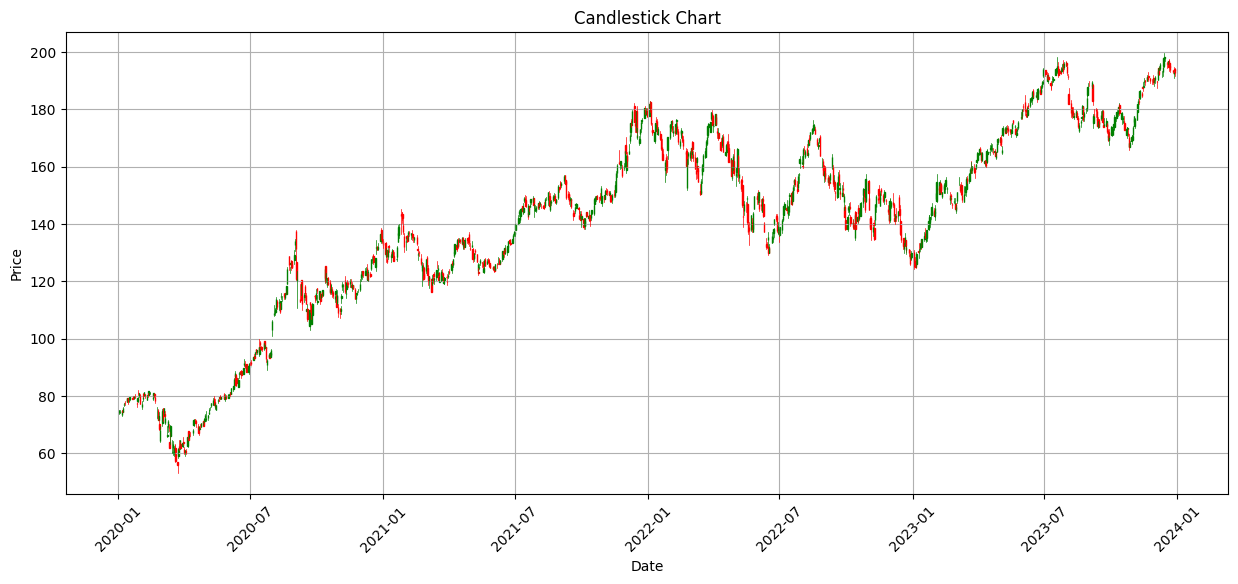

In [33]:
matplotlib_date = mdates.date2num(specific_df['Date'])
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T
plt.figure(figsize=(15,6))
ax=plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [34]:
specific_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018684,118387200,AAPL
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675285,108872000,AAPL
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200,AAPL


In [35]:
new_df = specific_df.reset_index()['Close']
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [36]:
from sklearn.model_selection import train_test_split
test_size = 0.2
train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

In [37]:
def generate_sequences_and_labels(data, n_past):
    sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
    labels = [data[i, 0] for i in range(n_past, len(data))]
    return np.array(sequences), np.array(labels)

In [38]:
n_past = 60
x_train, y_train = generate_sequences_and_labels(train_data, n_past)
x_test, y_test = generate_sequences_and_labels(test_data, n_past)

In [39]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

In [40]:
def build_lstm_model(input_shape):
  model = Sequential()
  model.add(LSTM(units=50, input_shape=[x_train.shape[1], 1]))
  model.add(Dense(10))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  return model

In [41]:
def compile_lstm_model(model):
  model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_absolute_error')

In [42]:
def train_lstm_model(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, batch_size=32, verbose=1)

In [43]:
model = build_lstm_model(x_train.shape[1])
compile_lstm_model(model)
train_lstm_model(model, x_train, y_train, x_test, y_test)

Epoch 1/300
24/24 [==============================] - 3s 39ms/step - loss: 0.1062 - mean_absolute_error: 0.2501 - val_loss: 0.0397 - val_mean_absolute_error: 0.1950
Epoch 2/300
24/24 [==============================] - 0s 12ms/step - loss: 0.0203 - mean_absolute_error: 0.1106 - val_loss: 0.0128 - val_mean_absolute_error: 0.1063
Epoch 3/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0152 - mean_absolute_error: 0.0963 - val_loss: 0.0080 - val_mean_absolute_error: 0.0815
Epoch 4/300
24/24 [==============================] - 0s 12ms/step - loss: 0.0130 - mean_absolute_error: 0.0888 - val_loss: 0.0051 - val_mean_absolute_error: 0.0629
Epoch 5/300
24/24 [==============================] - 0s 12ms/step - loss: 0.0108 - mean_absolute_error: 0.0816 - val_loss: 0.0041 - val_mean_absolute_error: 0.0560
Epoch 6/300
24/24 [==============================] - 0s 9ms/step - loss: 0.0101 - mean_absolute_error: 0.0777 - val_loss: 0.0032 - val_mean_absolute_error: 0.0494
Epoch 7/300
24/24

In [44]:
def make_predictions(model, x_train, x_test):
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    return train_predict, test_predict

In [45]:
train_predict, test_predict = make_predictions(model, x_train, x_test)

5/5 [==============================] - 0s 3ms/step


In [46]:
def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    return train_predict, test_predict

In [47]:
train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)

In [48]:
def evaluate_model(y_train, train_predict, y_test, test_predict):
    train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

In [49]:
evaluate_model(y_train, train_predict, y_test, test_predict)

Training RMSE: 138.7474153777896
Testing RMSE: 182.67532282696288


In [50]:
def plot_predictions(original_data, train_predict, test_predict, company_name):
    look_back = 60
    train_predict_plot = np.empty_like(original_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[look_back : len(train_predict) + look_back] = train_predict.flatten()

    test_predict_plot = np.empty_like(original_data)
    test_predict_plot[:] = np.nan
    test_start = len(original_data) - len(test_predict)
    test_predict_plot[test_start:] = test_predict.flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(original_data, color='black', label=f"Actual {company_name} price")
    plt.plot(train_predict_plot, color='red', label=f'Predicted {company_name} price (train_set)')
    plt.plot(test_predict_plot, color='blue', label=f"Predicted {company_name} price (test_set)")
    plt.title(f"{company_name} share price")
    plt.xlabel("Time")
    plt.ylabel(f"{company_name} share price")
    plt.legend()
    plt.show()

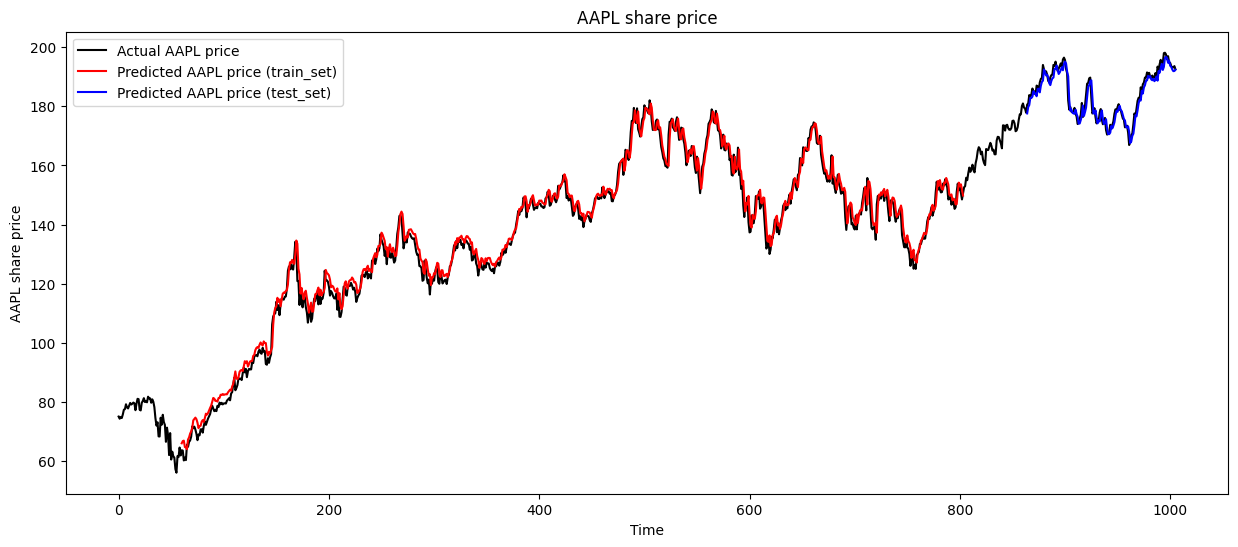

In [51]:
plot_predictions(new_df, train_predict, test_predict, company_name)

5/5 [==============================] - 0s 4ms/step
   Actual Close Prices  Predicted Close Prices
0           180.570007              177.586975
1           180.960007              179.744370
2           183.789993              180.411621
3           183.309998              182.895309
4           183.949997              182.806381


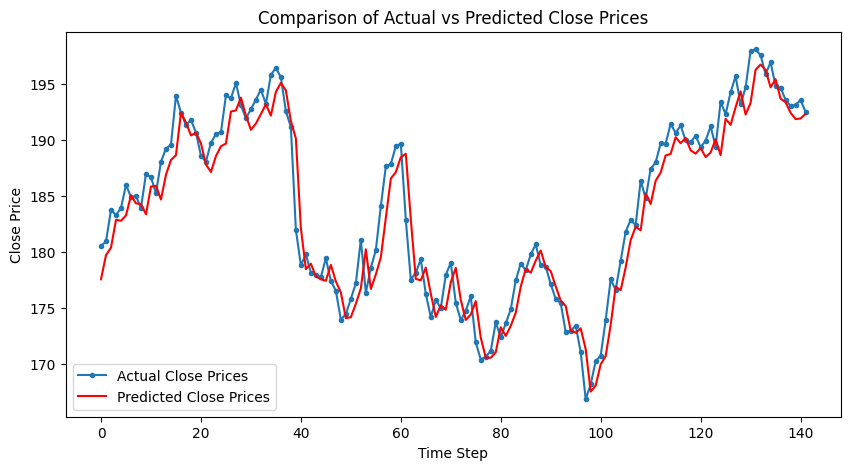

In [52]:
predictions = model.predict(x_test)

actual_values_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_values_inverse = scaler.inverse_transform(predictions)

comparison_df = pd.DataFrame({'Actual Close Prices': actual_values_inverse.flatten(), 'Predicted Close Prices': predicted_values_inverse.flatten()})
print(comparison_df.head())

plt.figure(figsize=(10, 5))
plt.plot(actual_values_inverse.flatten(), marker='.', label="Actual Close Prices")
plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.title('Comparison of Actual vs Predicted Close Prices')
plt.show()
